In [11]:
import re
from typing import List
import string
from collections import Counter
import numpy as np
import pandas as pd
from read_data import read_data

import unicodedata
import inflect

import nltk
#import install_nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import joblib

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder  
from sklearn.metrics import auc, roc_auc_score, roc_curve

%matplotlib inline

In [5]:
train, test = read_data()

/Users/guldenizbektas/Documents/turknet/notebooks/read_data.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  train = pd.read_sql_query("SELECT * FROM train;", conn)
/Users/guldenizbektas/Documents/turknet/notebooks/read_data.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test = pd.read_sql_query("SELECT * FROM test;", conn)


In the `data_processing` notebook, we examined the data. We looked at what could stay and what could go. We learned about texts. 

So let's set the steps:
- We will make the texts lower case.
- we will convert digits to text
- we will remove stopwords
- we will remove latin characters
- we will remove punctuations.

I am not sure yet about lemmatization. But since lemmatization doesn't cut the word abruptly like stemming, it cares about the meaning, I'll write a function for it as well.

In [6]:
def remove_equations(text):
    # Remove digits and mathematical equations
    text = re.sub(r'\$.*?\$', '', text)
    return text

def remove_punctuation(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def to_lowercase(text):
    # Convert to lowercase
    text = text.lower()
    return text

def remove_accents(text):
    # Remove accents from Latin letters
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8', 'ignore')
    return text

def tokenize_and_remove_stopwords(text):
    # Tokenize the text
    words = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Join the processed words back into a sentence
    processed_text = ' '.join(words)
    return processed_text

def lemmatize_text(text):
    # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the lemmatized words back into a sentence
    processed_text = ' '.join(lemmatized_words)
    return processed_text

def number_to_text(text):
    # Convert digits to text representation
    p = inflect.engine()
    words = []
    for word in text.split():
        if word.isdigit():
            words.append(p.number_to_words(word))
        else:
            words.append(word)
    processed_text = ' '.join(words)
    return processed_text

def stem_text(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    
    # Initialize the Porter stemmer
    stemmer = PorterStemmer()
    
    # Stem each word in the text
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Join the stemmed words back into a sentence
    processed_text = ' '.join(stemmed_words)
    
    return processed_text

def remove_website_links(text):
    # Regular expression to match website links
    processed_text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    
    return processed_text


In [4]:
def preprocess_text(text):
    # Apply each preprocessing step sequentially
    text = to_lowercase(text)
    text = remove_website_links(text)
    text = remove_equations(text)
    text = remove_punctuation(text)
    text = remove_accents(text)
    text = tokenize_and_remove_stopwords(text)
    text = lemmatize_text(text)
    text = number_to_text(text)
    #text = stem_text(text)
    return text

Let's give an extreme but in our case normal example:

`We consider the classic budgeted maximum weight independent set (BMWIS) problem. The input is a graph G=(V,E), a weight function w:V→ℝ≥0, a cost function c:V→ℝ≥0, and a budget B∈ℝ≥0. The goal is to find an independent set S⊆V in G such that ∑v∈Sc(v)≤B, which maximizes the total weight ∑v∈Sw(v). Since the problem on general graphs cannot be approximated within ratio |V|1−ε for any ε>0, BMWIS has attracted significant attention on graph families for which a maximum weight independent set can be computed in polynomial time. Two notable such graph families are bipartite and perfect graphs. BMWIS is known to be NP-hard on both of these graph families; however, the best possible approximation guarantees for these graphs are wide open.
In this paper, we give a tight 2-approximation for BMWIS on perfect graphs and bipartite graphs. In particular, we give We a (2−ε) lower bound for BMWIS on bipartite graphs, already for the special case where the budget is replaced by a cardinality constraint, based on the Small Set Expansion Hypothesis (SSEH). For the upper bound, we design a 2-approximation for BMWIS on perfect graphs using a Lagrangian relaxation based technique. Finally, we obtain a tight lower bound for the capacitated maximum weight independent set (CMWIS) problem, the special case of BMWIS where w(v)=c(v) ∀v∈V. We show that CMWIS on bipartite and perfect graphs is unlikely to admit an efficient polynomial-time approximation scheme (EPTAS). Thus, the existing PTAS for CMWIS is essentially the best we can expect.`

You can see these figures ∑,∈,ε,∀,⊆. This figures are not unprocessible by FastAPI. We'll remove them before getting input. And such representations are still on the math side, but they may not suggest as much logic in terms of operations as numbers or letters. Of course, we cannot say that they are absolutely useless, but we have to remove them for future problems.

In [5]:
text = "We consider the classic budgeted maximum weight independent set (BMWIS) problem. The input is a graph G=(V,E), a weight function w:V→ℝ≥0, a cost function c:V→ℝ≥0, and a budget B∈ℝ≥0. The goal is to find an independent set S⊆V in G such that ∑v∈Sc(v)≤B, which maximizes the total weight ∑v∈Sw(v). Since the problem on general graphs cannot be approximated within ratio |V|1−ε for any ε>0, BMWIS has attracted significant attention on graph families for which a maximum weight independent set can be computed in polynomial time. Two notable such graph families are bipartite and perfect graphs. BMWIS is known to be NP-hard on both of these graph families; however, the best possible approximation guarantees for these graphs are wide open. In this paper, we give a tight 2-approximation for BMWIS on perfect graphs and bipartite graphs. In particular, we give We a (2−ε) lower bound for BMWIS on bipartite graphs, already for the special case where the budget is replaced by a cardinality constraint, based on the Small Set Expansion Hypothesis (SSEH). For the upper bound, we design a 2-approximation for BMWIS on perfect graphs using a Lagrangian relaxation based technique. Finally, we obtain a tight lower bound for the capacitated maximum weight independent set (CMWIS) problem, the special case of BMWIS where w(v)=c(v) ∀v∈V. We show that CMWIS on bipartite and perfect graphs is unlikely to admit an efficient polynomial-time approximation scheme (EPTAS). Thus, the existing PTAS for CMWIS is essentially the best we can expect."
preprocess_text(text)


'consider classic budgeted maximum weight independent set bmwis problem input graph gve weight function wvR0 cost function cvR0 budget bR0 goal find independent set sv g vscvb maximizes total weight vswv since problem general graph approximated within ratio v1 zero bmwis attracted significant attention graph family maximum weight independent set computed polynomial time two notable graph family bipartite perfect graph bmwis known nphard graph family however best possible approximation guarantee graph wide open paper give tight 2approximation bmwis perfect graph bipartite graph particular give two lower bound bmwis bipartite graph already special case budget replaced cardinality constraint based small set expansion hypothesis sseh upper bound design 2approximation bmwis perfect graph using lagrangian relaxation based technique finally obtain tight lower bound capacitated maximum weight independent set cmwis problem special case bmwis wvcv vv show cmwis bipartite perfect graph unlikely a

Also `number_to_text` will only return as text if digit is alone without anything before or after it. For example "v1" will return as "v1" as it is. But "1" will return "one".

Let's apply these functions to our text.

In [7]:
train["clean_text"] = train.text.apply(preprocess_text)

In [8]:
train.head()

,category,text,clean_text
0,ai,Because of their occasional need to return to ...,occasional need return shallow point search tr...
1,ai,Market price systems constitute a well-underst...,market price system constitute wellunderstood ...
2,ai,We describe an extensive study of search in GS...,describe extensive study search gsat approxima...
3,ai,As real logic programmers normally use cut (!)...,real logic programmer normally use cut effecti...
4,ai,To support the goal of allowing users to recor...,support goal allowing user record retrieve inf...


In [9]:
test["clean_text"] = test.text.apply(preprocess_text)

In [10]:
test.head()

,category,text,clean_text
0,ai,This paper presents a novel approach based on ...,paper present novel approach based variable fo...
1,ai,"In an open, constantly changing and collaborat...",open constantly changing collaborative environ...
2,ai,This volume contains the papers presented at t...,volume contains paper presented fifth workshop...
3,ai,We present a general framework for defining pr...,present general framework defining prior model...
4,ai,"Possibility theory offers either a qualitive, ...",possibility theory offer either qualitive nume...


In [7]:
# shuffle the data
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

# target will be the numerical value of the class
labeler = LabelEncoder()
train["target"] = labeler.fit_transform(train["category"])
test["target"] = labeler.transform(test["category"])

# make ready for human readable results
mapping = dict(zip(labeler.classes_, range(len(labeler.classes_))))
mapping

{'ai': 0, 'cv': 1, 'ds': 2, 'ml': 3}

Let's look at an example for stemming and lemmatizing.

In [12]:
txt = "Two notable such graph families are bipartite and perfect graphs. BMWIS is known to be NP-hard on both of these graph families; however, the best possible approximation guarantees for these graphs are wide open."
print("lemmatized text:", lemmatize_text(txt))
print("stemmed text:", stem_text(txt))

lemmatized text: Two notable such graph family are bipartite and perfect graph . BMWIS is known to be NP-hard on both of these graph family ; however , the best possible approximation guarantee for these graph are wide open .
stemmed text: two notabl such graph famili are bipartit and perfect graph . bmwi is known to be np-hard on both of these graph famili ; howev , the best possibl approxim guarante for these graph are wide open .


Stemmed text cut the word and looks meaningles but for model it might be different. In my proffessional life it didn't make anything better for my tasks. So I can try it for one model.

In [13]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['AI', 'CV', 'DS', "ML"]
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

## Model Selection

I'll try SVC model with stemming because I get good results without stemming.

In [8]:
def preprocess_text(text):
    # Apply each preprocessing step sequentially
    text = to_lowercase(text)
    text = remove_website_links(text)
    text = remove_equations(text)
    text = remove_punctuation(text)
    text = remove_accents(text)
    text = tokenize_and_remove_stopwords(text)
    text = lemmatize_text(text)
    text = number_to_text(text)
    text = stem_text(text)
    return text

train["stemmed_text"] = train.text.apply(preprocess_text)

In [9]:
test["stemmed_text"] = test.text.apply(preprocess_text)

In [16]:
pipeline = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', SVC(C=10, gamma="scale", kernel="rbf"))])

model = pipeline.fit(train["stemmed_text"], train["target"])

pred  = model.predict(test["stemmed_text"])

print(classification_report(test["target"],
                            pred, 
                            target_names=mapping))

              precision    recall  f1-score   support

          ai       0.87      0.93      0.90       500
          cv       0.96      0.91      0.93       500
          ds       0.95      0.90      0.92       500
          ml       0.87      0.91      0.89       500

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



Well, doesn't look bad. Let's try it without it.

In [17]:
pipeline2 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', SVC(C=10, gamma="scale", kernel="rbf"))])

model2 = pipeline2.fit(train["clean_text"], train["target"])

pred2  = model2.predict(test["clean_text"])

print(classification_report(test["target"],
                            pred2, 
                            target_names=mapping))

              precision    recall  f1-score   support

          ai       0.88      0.94      0.91       500
          cv       0.95      0.91      0.93       500
          ds       0.94      0.90      0.92       500
          ml       0.88      0.90      0.89       500

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



Only f1 score for AI has increased. recall for ml has decreased. well maybe this are not a big changes. but it works with stemming too.

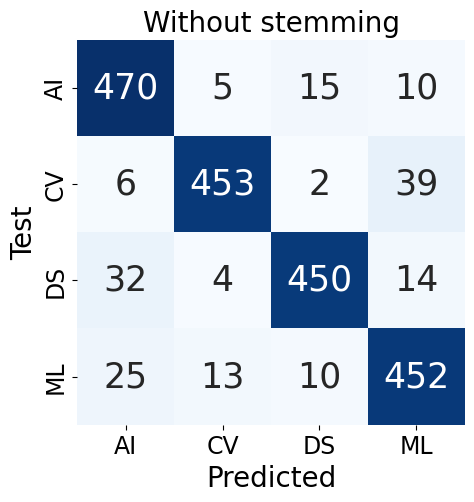

In [18]:
conf_matrix(test["target"],
            pred2,
           "Without stemming")

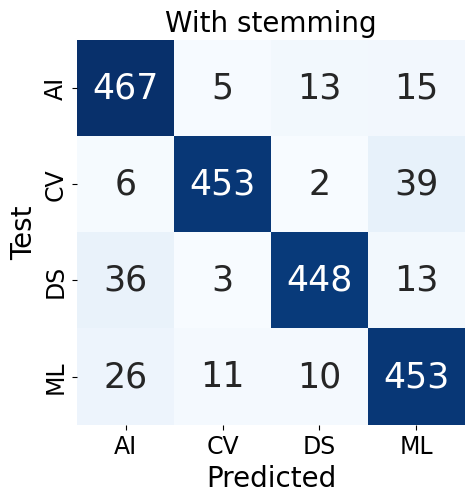

In [19]:
conf_matrix(test["target"],
            pred,
           "With stemming")

Since the results are good. Let's apply `countvectorizer` and `TfidfTransformer` for `clean_text` and `stemmed_text`. We're creating them to perform grid search to find the **best parameters**.

In [20]:
vectorizer = CountVectorizer()
train_cv = vectorizer.fit_transform(train["clean_text"])
print(train_cv.shape)

tfidf = TfidfTransformer()
train_tfidf = tfidf.fit_transform(train_cv)
print(train_tfidf.shape)

test_cv = vectorizer.transform(test["clean_text"])
test_tfids = tfidf.transform(test_cv)

(6000, 25750)
(6000, 25750)


In [21]:
vectorizer = CountVectorizer()
train_cv_stm = vectorizer.fit_transform(train["stemmed_text"])
print(train_cv_stm.shape)

tfidf = TfidfTransformer()
train_tfidf_stm = tfidf.fit_transform(train_cv_stm)
print(train_tfidf_stm.shape)

test_cv_stm = vectorizer.transform(test["stemmed_text"])
test_tfids_stm = tfidf.transform(test_cv_stm)

(6000, 20432)
(6000, 20432)


In [22]:
# Lets create model:
from plotly.offline import iplot,plot
from plotly.offline import init_notebook_mode, iplot,plot
init_notebook_mode(connected=True)

def classification_models(model):
    y_pred=model.fit(train_tfidf,train["target"]).predict(test_tfids)
    accuracy=accuracy_score(test["target"], y_pred)
    f1=f1_score(test["target"], y_pred, average="weighted")
    precision=precision_score(test["target"], y_pred, average="weighted")
    recall=recall_score(test["target"], y_pred, average="weighted")
    
    results=pd.DataFrame({"Values":[accuracy,f1,precision,recall],
                         "Metrics":["Accuracy","F1","Precision","Recall"]})
    
    # Visualize Results:
    fig=make_subplots(rows=1,cols=1)
    fig.add_trace(go.Bar(x=[round(i,5) for i in results["Values"]],
                        y=results["Metrics"],
                        text=[round(i,5) for i in results["Values"]],orientation="h",textposition="inside",name="Values",
                        marker=dict(color=["indianred","firebrick","palegreen","skyblue","plum"],line_color="beige",line_width=1.5)),row=1,col=1)
    fig.update_layout(title={'text': model.__class__.__name__ ,
                             'y':0.9,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    fig.update_xaxes(range=[0,1], row = 1, col = 1)

    iplot(fig)

my_models= [
    
    LogisticRegression(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    DecisionTreeClassifier(),
    SVC()


]

for model in my_models:
    classification_models(model)

Without stemmed text Logistic Reg and SVC passed the %90 f1 score barrier. I usually look at f1 score in ml algorithms since it harmonic mean of recall and precision. More accurate than accuracy. Let's try with stemmed texts.

In [23]:
def classification_models(model):
    y_pred=model.fit(train_tfidf_stm,train["target"]).predict(test_tfids_stm)
    accuracy=accuracy_score(test["target"], y_pred)
    f1=f1_score(test["target"], y_pred, average="weighted")
    precision=precision_score(test["target"], y_pred, average="weighted")
    recall=recall_score(test["target"], y_pred, average="weighted")
    
    results=pd.DataFrame({"Values":[accuracy,f1,precision,recall],
                         "Metrics":["Accuracy","F1","Precision","Recall"]})
    
    # Visualize Results:
    fig=make_subplots(rows=1,cols=1)
    fig.add_trace(go.Bar(x=[round(i,5) for i in results["Values"]],
                        y=results["Metrics"],
                        text=[round(i,5) for i in results["Values"]],orientation="h",textposition="inside",name="Values",
                        marker=dict(color=["indianred","firebrick","palegreen","skyblue","plum"],line_color="beige",line_width=1.5)),row=1,col=1)
    fig.update_layout(title={'text': model.__class__.__name__ ,
                             'y':0.9,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    fig.update_xaxes(range=[0,1], row = 1, col = 1)

    iplot(fig)

my_models= [
    
    LogisticRegression(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    DecisionTreeClassifier(),
    SVC()


]

for model in my_models:
    classification_models(model)

In both SVC and Logistic won to be honest. And about stemmed and without stemmed... they are extremely close. So for ML let's go with stemmed since it wont hurt.

Now we can find the best hyperparameters for Logistic and SVC to decide which one is the best.

SVC F1 Score -> 0.90889

Logistic Regression -> 0.90828

### Grid search for SVC

In [24]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(train_tfidf_stm, train["target"])

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.8845000000000001


In [25]:
best_svc = SVC(C=10, gamma="scale", kernel="rbf")
best_svc.fit(train_tfidf_stm, train["target"])
best_svc_preds = best_svc.predict(test_tfids_stm)

accuracy=accuracy_score(test["target"], best_svc_preds)
f1=f1_score(test["target"], best_svc_preds, average="weighted")
precision=precision_score(test["target"], best_svc_preds, average="weighted")
recall=recall_score(test["target"], best_svc_preds, average="weighted")

results_svc=pd.DataFrame({"Values":[accuracy,f1,precision,recall],
                     "Metrics":["Accuracy","F1","Precision","Recall"]})

# Visualize Results:
fig=make_subplots(rows=1,cols=1)
fig.add_trace(go.Bar(x=[round(i,5) for i in results_svc["Values"]],
                    y=results_svc["Metrics"],
                    text=[round(i,5) for i in results_svc["Values"]],orientation="h",textposition="inside",name="Values",
                    marker=dict(color=["indianred","firebrick","palegreen","skyblue","plum"],line_color="beige",line_width=1.5)),row=1,col=1)
fig.update_layout(title={'text': "SVC Best Model",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  template='plotly_white')
fig.update_xaxes(range=[0,1], row = 1, col = 1)

iplot(fig)

Wow, with grid search we find the best parameters for our model and increased the score for %1.

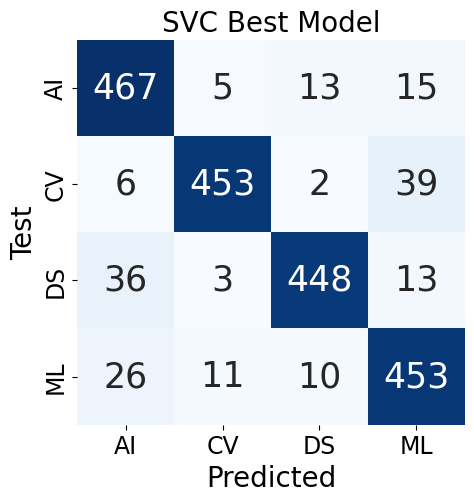

In [26]:
conf_matrix(test["target"], best_svc_preds, "SVC Best Model")

In [27]:
print(classification_report(test["target"], best_svc_preds))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       500
           1       0.96      0.91      0.93       500
           2       0.95      0.90      0.92       500
           3       0.87      0.91      0.89       500

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



### Logistic Regression Grid Search

In [28]:
logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1.0, 10.0],          # Regularization strength (smaller values specify stronger regularization)
    'penalty': ['l1', 'l2'],       # Regularization type ('l1' for L1 regularization, 'l2' for L2 regularization)
    'class_weight': [None, 'balanced']  # Class weights ('None' for no class weights, 'balanced' for auto class weights)
}

# Create the GridSearchCV object
grid_search = GridSearchCV(logreg_model, param_grid, cv=5)

# Fit the GridSearchCV to the data
grid_search.fit(train_tfidf_stm, train["target"])


# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

/Users/guldenizbektas/Documents/turknet_final/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/guldenizbektas/Documents/turknet_final/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Best Parameters: {'C': 1.0, 'class_weight': None, 'penalty': 'l2'}
Best Score: 0.8798333333333332


In [29]:
best_log = LogisticRegression(multi_class="multinomial", C=1.0,
                             class_weight=None)
best_log.fit(train_tfidf_stm, train["target"])
best_log_preds = best_log.predict(test_tfids_stm)

accuracy=accuracy_score(test["target"], best_log_preds)
f1=f1_score(test["target"], best_log_preds, average="weighted")
precision=precision_score(test["target"], best_log_preds, average="weighted")
recall=recall_score(test["target"], best_log_preds, average="weighted")

results_svc=pd.DataFrame({"Values":[accuracy,f1,precision,recall],
                     "Metrics":["Accuracy","F1","Precision","Recall"]})

# Visualize Results:
fig=make_subplots(rows=1,cols=1)
fig.add_trace(go.Bar(x=[round(i,5) for i in results_svc["Values"]],
                    y=results_svc["Metrics"],
                    text=[round(i,5) for i in results_svc["Values"]],orientation="h",textposition="inside",name="Values",
                    marker=dict(color=["indianred","firebrick","palegreen","skyblue","plum"],line_color="beige",line_width=1.5)),row=1,col=1)
fig.update_layout(title={'text': "Logistic Regression Best Model",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  template='plotly_white')
fig.update_xaxes(range=[0,1], row = 1, col = 1)

iplot(fig)

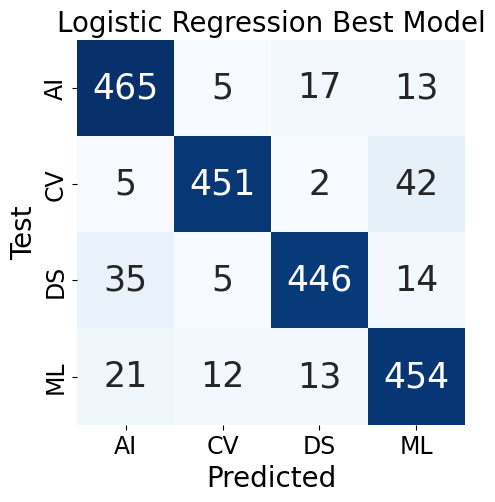

In [30]:
conf_matrix(test["target"], best_log_preds, "Logistic Regression Best Model")

In [31]:
print(classification_report(test["target"], best_log_preds))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       500
           1       0.95      0.90      0.93       500
           2       0.93      0.89      0.91       500
           3       0.87      0.91      0.89       500

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



Aaaaand SVC gives a better result than Logistic regression by far. Let's save the model for later.

In [32]:
pipeline3 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', SVC(C=10, gamma="scale", kernel="rbf"))])

pipeline3.fit(train["stemmed_text"], train["target"])

joblib.dump(pipeline3, "models/svc_best_model_stemmed.joblib")


['models/svc_best_model_stemmed.joblib']

In [12]:
pipeline3 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', SVC(C=10, gamma="scale", kernel="rbf"))])

pipeline3.fit(train["stemmed_text"], train["target"])


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', SVC(C=10))])

In [13]:
accuracy_score(train["target"], pipeline3.predict(train["stemmed_text"]))

0.9998333333333334

In [15]:
f1_score(train["target"], pipeline3.predict(train["stemmed_text"]), average="weighted")

0.9998333333148148

In [16]:
pipeline4 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', LogisticRegression(multi_class="multinomial", C=1.0,
                             class_weight=None))])

pipeline4.fit(train["stemmed_text"], train["target"])
print(accuracy_score(train["target"], pipeline4.predict(train["stemmed_text"])))
print(f1_score(train["target"], pipeline4.predict(train["stemmed_text"]), average="weighted"))

0.9475
0.9474821753671713


In [17]:
joblib.dump(pipeline4, "logreg_best_model_stemmed.joblib")


['logreg_best_model_stemmed.joblib']